**You Wu**

#Se discreto

Estamos acostumbrados a trabajar con datos continuos, pero a veces es más fácil cruzar al mundo discreto por diferentes motivos. En este problema vamos a experimentar con diferentes discretizaciones.

In [1]:
!pip3 install pmlb --upgrade --quiet
from pmlb import fetch_data

In [2]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler, KBinsDiscretizer

from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from yellowbrick.classifier import roc_auc, precision_recall_curve
from yellowbrick.target.feature_correlation import feature_correlation

from IPython.display import display, HTML

import warnings

###Funciones que utilizamos durante el proceso

Cargamos el conjuntos de datos *apendicitis* que esta incluido en los Penn Machine Learning BenchMarks.

In [3]:
data = fetch_data('appendicitis')
data.to_csv('appendicitis.csv', index=False) 
data

,At1,At2,At3,At4,At5,At6,At7,target
0,0.213,0.554,0.207,0.000,0.000,0.749,0.220,1
1,0.458,0.714,0.468,0.111,0.102,0.741,0.436,1
2,0.102,0.518,0.111,0.056,0.022,0.506,0.086,1
3,0.187,0.196,0.105,0.056,0.029,0.133,0.085,1
4,0.236,0.804,0.289,0.111,0.066,0.756,0.241,1
...,...,...,...,...,...,...,...,...
101,0.449,0.875,0.523,0.083,0.076,0.920,0.487,0
102,0.102,0.000,0.022,0.000,0.000,0.000,0.017,0
103,0.409,0.875,0.482,0.306,0.259,0.914,0.443,0
104,0.427,0.804,0.474,0.056,0.048,0.836,0.437,0


In [4]:
data.describe(include='all')

,At1,At2,At3,At4,At5,At6,At7,target
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.398491,0.682104,0.415151,0.208745,0.169151,0.676349,0.375396,0.198113
std,0.191452,0.207134,0.205799,0.199650,0.177329,0.218909,0.198132,0.400471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.244750,0.589000,0.277000,0.056000,0.049250,0.576000,0.238000,0.000000
50%,0.413000,0.750000,0.442500,0.146000,0.113000,0.744000,0.397500,0.000000
75%,0.505750,0.821000,0.545500,0.302500,0.226750,0.831250,0.486750,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


El conjunto de datos está compuesto solamente por atributos numéricos.

In [5]:
data['target'].value_counts()

0    85
1    21
Name: target, dtype: int64

Podemos ver el balance entre las dos clases del conjunto de datos está desequilibrado, la mayoría son de la clase 0.



Examinamos el número de valores NAs para cada variables, obtenimos el resultado en el que todos ellos estan asignados a un valor. 

In [6]:
data.isna().sum()

At1       0
At2       0
At3       0
At4       0
At5       0
At6       0
At7       0
target    0
dtype: int64

##Apartado A
### División de los datos

Dividimos los datos en conjuntos de entrenamiento y test (60%/40%) con validación cruzada sobre la partición de entrenamiento para decidir los hiperparámetros.

In [7]:
X = data.loc[:, data.columns != 'target']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=33)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63, 7) (63,)
(43, 7) (43,)


#Apartado B

##Preprocessing
Antes de entrenar distintos modelos tenemos que preprocesar los datos adecuadamente para estos models en este caso consiste en estandarizar los variables.

In [8]:
def minimum_preprocessing(X_train, X_test):
  X_train_preprocessed = X_train.copy(deep=True)
  X_test_preprocessed = X_test.copy(deep=True)
  #Scale variables using standard scaler
  scale = StandardScaler()
  X_train_preprocessed = scale.fit_transform(X_train_preprocessed)
  X_test_preprocessed = scale.transform(X_test_preprocessed)
  return X_train_preprocessed,X_test_preprocessed

In [9]:
X_trainStan, X_testStan = minimum_preprocessing(X_train, X_test);

In [10]:
cls = [str(v) for v in sorted(data['target'].unique())]


In [11]:
numericals_results = {}

##Naive Bayes

Primero de todo hemos creado una función donde se guarda los resultados obtenidos de los modelos, en los cual son: *accuracy*, *precission*, *recall*, *f1-score*

In [12]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

Dado que los datos son continuos, podemos asumir que se distribuyen segun gausianas

In [13]:
gnb = GaussianNB()

In [14]:
gnb_model = gnb.fit(X_trainStan, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X.columns
means

Priors: [0.79365079 0.20634921]
Means:



,At1,At2,At3,At4,At5,At6,At7
0,0.157725,0.224334,0.187220,0.158645,0.173259,0.207126,0.172311
1,-0.606636,-0.862821,-0.720078,-0.610172,-0.666382,-0.796640,-0.662736


In [15]:
report_GNB = (classification_report(gnb_model.predict(X_testStan), y_test,target_names=cls))
results_df = save_results(gnb_model, X_testStan, y_test, 'GNB', results_df)

In [16]:
cv_GNB = np.mean(cross_val_score(gnb,X_trainStan,y_train,cv=10))
et_GNB = gnb_model.score(X_testStan, y_test)
numericals_results['GNB'] = {
    "cross_validation": cv_GNB,
    "test_error":et_GNB,
}


##Regresión logística

In [17]:
lr = LogisticRegression(max_iter=1000)

En Regresión Logística si tenemos de hiperparámetros que exploraremos para utilizar los que mejores resultados nos proporcionen. Una vez tengamos estos hiperparámetros, los aplicaremos a nuestro modelo y veremos que porcentaje de acierto obtenemos con el conjunto de test.

In [18]:
param = {'penalty':['l2','none'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_trainStan, y_train);

In [19]:
show_html = lambda html: display(HTML(html))
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
28,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.864286,1
14,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.864286,1
26,"{'C': 7.943282347242813, 'penalty': 'l2'}",0.864286,1
32,"{'C': 63.0957344480193, 'penalty': 'l2'}",0.864286,1
30,"{'C': 31.622776601683793, 'penalty': 'l2'}",0.864286,1


Puede haber varios valores de hiperparametros que obtengan el mismo resultado, en ese caso elegiriamos cualquiera de entre ellos. 

En este caso podemos ver como usando l2 como penalty y escogiendo un valor de C igual a 15.84, 0.13, 7.94, 63.09 o 31.62, obtenemos los mejores resultados (acierto del 86,4%).

Coefs:
Index(['At1', 'At2', 'At3', 'At4', 'At5', 'At6', 'At7'], dtype='object')


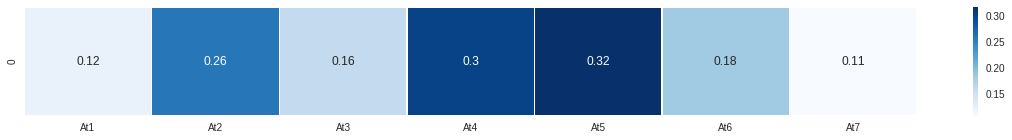

In [20]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns
print(coefs.columns)
plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size':12});

Esta matriz de coeficientes nos indica, para cada variable y clase, lo siguiente. Por cada aumento en una unidad en una de las variables, la clase incremente por el valor del coeficiente, mientras las otras variables se mantienen constantes.

In [21]:
c = lr_gs.best_params_['C']
lr = LogisticRegression(max_iter=1000, C=c)
lr_model = lr.fit(X_trainStan, y_train)

In [22]:
report_LR = (classification_report(lr_gs.predict(X_testStan), y_test,target_names=cls))
results_df = save_results(lr_model, X_testStan, y_test, 'LR', results_df)


In [23]:
cv_LR = (np.mean(cross_val_score(lr,X_trainStan,y_train,cv=10)))
te_LR = lr_gs.score(X_testStan, y_test)
numericals_results['LR'] = {
    "cross_validation": cv_LR,
    "test_error":te_LR,
}

##KNN

K-nn funciona a partir de la recuperación de los vecinos más cercanos a partir de su distancia.

In [24]:
knn =  KNeighborsClassifier()

Hemos definido una función para explorar el rango de hiperparámetos de K-nn, basicamente cuantos vecinos usamos para hacer la predicción para obtener las mejores resultados.

In [25]:
param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
        'weights':['distance', 'uniform'], 
        'leaf_size':[1, 5, 10, 20, 30],
        'metric': ['l2', 'l1', 'cosine']}   
knn_gs =  GridSearchCV(KNeighborsClassifier(),param,cv=10, n_jobs=-1)
knn_gs.fit(X_train, y_train);
print("GridSearch: n_neightbors ",knn_gs.best_params_['n_neighbors'])
best_nneighbors = knn_gs.best_params_['n_neighbors']


GridSearch: n_neightbors  3


En el caso de que haya más de un hiperparámetro dan el mejor resultado nos funcionaria cualquiera de esta, en este caso utilizamos 3 vecinos más cercanos.

In [26]:
best_nneighbors = knn_gs.best_params_['n_neighbors']
knn =  KNeighborsClassifier(n_neighbors=best_nneighbors)
knn_model = knn.fit(X_trainStan, y_train)

In [27]:
report_KNN = (classification_report(knn_model.predict(X_testStan), y_test,target_names=cls))
results_df = save_results(knn_model, X_testStan, y_test, 'KNN', results_df)

In [28]:
cv_KNN = (np.mean(cross_val_score(knn_model,X_trainStan,y_train,cv=10)))
te_KNN = knn_model.score(X_testStan, y_test)
numericals_results['KNN'] = {
    "cross_validation": cv_KNN,
    "test_error":te_KNN,
}


##Resultados
Una vez entrenando con los modelos: naive bayes,  regresión logística y K nearest neightbors, vamos analizar y comparar sus resultados.
Primer tenemos los reportes de clasificaciones.

In [29]:
print(report_GNB)

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        34
           1       0.75      0.67      0.71         9

    accuracy                           0.88        43
   macro avg       0.83      0.80      0.82        43
weighted avg       0.88      0.88      0.88        43



In [30]:
print(report_LR)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        40
           1       0.38      1.00      0.55         3

    accuracy                           0.88        43
   macro avg       0.69      0.94      0.74        43
weighted avg       0.96      0.88      0.91        43



In [31]:
print(report_KNN)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        38
           1       0.50      0.80      0.62         5

    accuracy                           0.88        43
   macro avg       0.74      0.85      0.77        43
weighted avg       0.92      0.88      0.89        43



Los resultados obtenidos en los reportes de classificación son muy aparecidos, pero fijando bien podemos observar que Naive Bayes es ligeramente mejor que otro dos, ya que tiene una precisión mejor para ambos tipos de pacientes. 

In [32]:
results = pd.DataFrame(numericals_results)
results.T.sort_values('test_error').round(3)

,cross_validation,test_error
GNB,0.862,0.884
LR,0.864,0.884
KNN,0.864,0.884


Con los resultados obtenidos de la medias de validación cruzada y error de test podemos observar que en los tres obtenemos buenos resultados.

In [33]:
results_df.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
GNB,0.883721,0.890105,0.883721,0.886298
LR,0.883721,0.898256,0.883721,0.861170
KNN,0.883721,0.877111,0.883721,0.872693


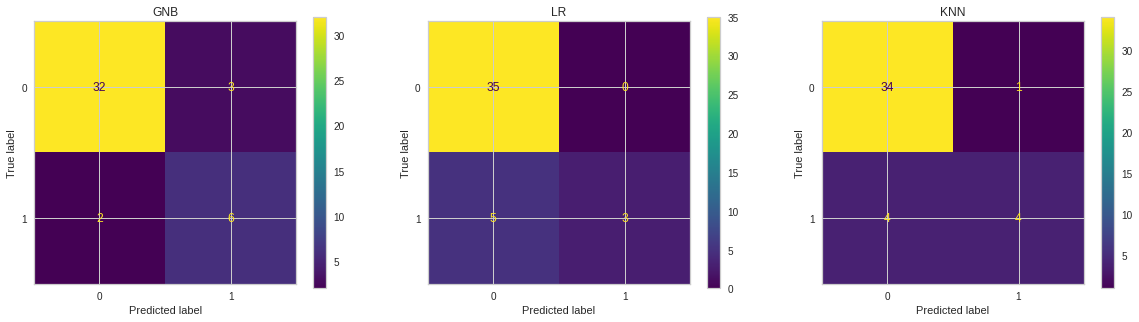

In [34]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
ConfusionMatrixDisplay.from_estimator(gnb_model, X_testStan,y_test, display_labels=cls, ax=ax[0]);
ConfusionMatrixDisplay.from_estimator(lr_gs, X_testStan,y_test, display_labels=cls, ax=ax[1]);
ConfusionMatrixDisplay.from_estimator(knn_model, X_testStan,y_test, display_labels=cls, ax=ax[2])
ax[0].title.set_text("GNB")
ax[1].title.set_text("LR")
ax[2].title.set_text("KNN")

Las matrices de confusión de cada uno de los modelos muestran resultados similares. En este caso podemos observar que regressión logistico, que tiene el recuerdo más alto en el informe con la clase 0, predice 5 falsos negativos que solo difiere con los otros modelos en 1.

#Apartado C

La función que tenemos a continuación nos permite obtener resultados sobre el error de test y de la media de la validación cruzada, de distintos modelos de clasificación con los hiperparámetros encontrados.

In [35]:
def results_numerics(X_train, X_test, y_train, y_test, n_neighbors=5, c=1): 
  models = {
    "GNB":GaussianNB(),
    "LR":LogisticRegression(max_iter=1000, C=c),
    "KNN":KNeighborsClassifier(n_neighbors=n_neighbors)
  }

  results_numeric = {}
  for name,model in models.items():
      current_model = model.fit(X_train,y_train)
      cv = cross_val_score(model,X_train,y_train,cv=10)
      test = current_model.score(X_test, y_test)
      result_numeric = {
          "cross_validation":cv.mean(),
          "test_error":test,
      }
      results_numeric[name] = result_numeric
  return results_numeric

In [36]:
def knn_neightbors(X_train,y_train):
  param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}   
  knn_gs =  GridSearchCV(KNeighborsClassifier(),param,cv=10, n_jobs=-1)
  knn_gs.fit(X_train, y_train);
  print("GridSearch: n_neightbors ",knn_gs.best_params_['n_neighbors'])
  return knn_gs.best_params_['n_neighbors']


In [37]:
def C_values(X_train,y_train):
  lr = LogisticRegression(max_iter=1000)
  param = {'penalty':['l2', 'none'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
  lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
  lr_gs.fit(X_train, y_train);
  print("GridSearch: Cs ",lr_gs.best_params_['C'])
  return lr_gs.best_params_['C']

In [38]:
def preprocessing_Dicretizer(X_train, X_test,bins=0,new_strategy=''):
  X_train_preprocessed = X_train.copy(deep=True)
  X_test_preprocessed = X_test.copy(deep=True)
  #Discretize variables according to parameters
  if (bins!=0):
    kBinDiscretizer = KBinsDiscretizer(n_bins=bins, encode='onehot-dense', strategy=new_strategy)
    kBinDiscretizer.fit(X_train)
    X_train_preprocessed = kBinDiscretizer.transform(X_train_preprocessed)
    kBinDiscretizer.fit(X_test)
    X_test_preprocessed = kBinDiscretizer.transform(X_test_preprocessed)
  #Scale variables
  scale = StandardScaler()
  X_train_preprocessed = scale.fit_transform(X_train_preprocessed)
  X_test_preprocessed = scale.transform(X_test_preprocessed)
  return X_train_preprocessed,X_test_preprocessed


Discretizar datos continues mediantes KBinsDiscretizer con discrezaciones:
 - quantile
 - kmeans


Con n_bins = 2, 3 o 4

Preprocessar los datos con cada una de las estrategias y numero de bins. Y processar los tres modelos y obtener los errores de la validación cruzada y de test.

In [39]:
n_bins_list = [2,3,4]
discretization_results = {}
aux_results1 = {}
aux_results2 = {}

for n_bins in n_bins_list:
  print("\n\nn_bins = "+ str(n_bins))
  print("Quantile Strategy")
  X_trainD,X_testD = preprocessing_Dicretizer(X_train, X_test,bins=n_bins,new_strategy='quantile')
  n_neighbors1 = knn_neightbors(X_trainD,y_train)
  c1 = C_values(X_trainD,y_train)
  results1 =  results_numerics(X_trainD, X_testD, y_train, y_test, n_neighbors1, c1)
  aux_results1[n_bins] = results1
  discretization_results['quantile'] = aux_results1

  print("\nKmeans Strategy")
  X_trainK,X_testK = preprocessing_Dicretizer(X_train, X_test,bins=n_bins,new_strategy='kmeans')  
  n_neighbors2 = knn_neightbors(X_trainK,y_train)
  c2 = C_values(X_trainK,y_train)
  results2 =  results_numerics(X_trainK, X_testK, y_train, y_test, n_neighbors2, c2) 
  aux_results2[n_bins] = results2
  discretization_results['kmeans'] = aux_results2




n_bins = 2
Quantile Strategy
GridSearch: n_neightbors  5
GridSearch: Cs  0.0630957344480193

Kmeans Strategy
GridSearch: n_neightbors  11
GridSearch: Cs  0.1096478196143185


n_bins = 3
Quantile Strategy
GridSearch: n_neightbors  7
GridSearch: Cs  0.047863009232263824

Kmeans Strategy
GridSearch: n_neightbors  15
GridSearch: Cs  0.1445439770745928


n_bins = 4
Quantile Strategy
GridSearch: n_neightbors  15
GridSearch: Cs  0.02754228703338166

Kmeans Strategy
GridSearch: n_neightbors  5
GridSearch: Cs  0.0630957344480193


Convertir los resultos a DataFrame para poder visulizarlo.

In [40]:
results_n = results.T.copy(deep=True)
results_n.index = pd.MultiIndex.from_product([[0], results_n.index ], names=['bins', 'model'])
quantile_df = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in discretization_results['quantile'].items()
    }, 
    axis=0)
kmeans_df = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in discretization_results['kmeans'].items()
    }, 
    axis=0)
results_df = pd.concat([ quantile_df, kmeans_df,results_n ], keys=['quantile','kmeans','baseline'],axis=0)
results_df.index.names = ['strategy','bins','model']
sorted_results = results_df.sort_values('test_error',ascending=False).round(3)
sorted_results

cross_validation  test_error
strategy bins model                              
kmeans   2    LR                0.848       0.907
         3    KNN               0.831       0.907
         2    KNN               0.831       0.907
quantile 4    KNN               0.848       0.884
baseline 0    LR                0.864       0.884
              GNB               0.862       0.884
kmeans   4    LR                0.893       0.884
baseline 0    KNN               0.864       0.884
kmeans   3    LR                0.893       0.860
quantile 3    KNN               0.879       0.860
kmeans   4    KNN               0.812       0.860
quantile 4    LR                0.895       0.837
         3    LR                0.867       0.837
         2    KNN               0.876       0.814
              LR                0.876       0.791
              GNB               0.812       0.791
         4    GNB               0.619       0.674
kmeans   4    GNB               0.555       0.674
quantile 3    GNB               0.650       0.628
kmeans   2    GNB               0.283       0.349
         3    GNB               0.476       0.279

Mirando los resultados obtenidos podemos decir que, ambos procesos no ha afectado mucho la calidad de los modelos, todo y que se obtiene bastantas buenas resultados con la estrategia *kmeasn*. En el DataFrame los mejores resultados se obtiene con los modelos KNN y Logistic regresion independientemente de las estrategias.

Text(0.5, 0.98, 'Cross Validation and Test errors of Trained Models')

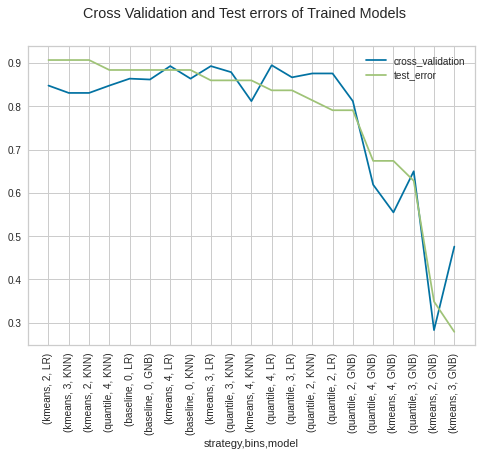

In [41]:
ax = sorted_results.plot(rot=90,xticks=np.arange(0,21))
plt.suptitle("Cross Validation and Test errors of Trained Models")

A partir del plot anterior podemos observar que el mejor resultado se obtiene mediante baseline con el modelo Logistic Regression

#Apartado D


Como hemos visto anteriormente, trabajar con datos discretizados mejora el rendimiento de algunos modelos en ciertas condiciones (Regresión logística con 3 bins, KNN con más bins) pero para otros (Bayes) empeora
el desempeño.  Con los resultados obtenidos no parece tener un impacto significativo. Quizás explorando una gama más amplia de bins nos permitiría poder obtener algunos resultados significativos.